
## https://www.ree.es/es/apidatos

In [19]:
%load_ext autoreload
%autoreload 2
import json
import os
import re
import sys
from datetime import date, datetime
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import requests
from sklearn.preprocessing import MinMaxScaler

cwd = Path.cwd()
home = Path.home()
module_path = f"{home}/serhi/src/lib" if cwd == home else f"{cwd.parents[1]}/lib"
sys.path.append(module_path)
import serhi

In [20]:
# inicio
# cambiar como corresponda

ENTITY = 'ree'
NB_NAME = 'ree_componentes_precio_energia'
serhi.initialize(ENTITY, NB_NAME)

In [22]:
# preparamos array con los lotes a descargar
# cada llamada a la api permite un máximo de 24 meses
# la primera fecha disponible es ene-2014

dates = []

for i in range(2014, 2021, 2):
    dates.append({
        'start_date': date(i, 1, 1),
        'end_date': date(i+1, 12, 31)
    })

dates.append({
    'start_date': date(i+2, 1, 1),
    'end_date': date.today()
})


In [23]:
# url de la api
url = 'https://apidatos.ree.es/es/datos/mercados/componentes-precio-energia-cierre-desglose'

In [24]:
# descargamos los datos y los vamos añadiendo 

df = pd.DataFrame()

for p in range(len(dates)):
    r = requests.get(url,
                     params={
                         'start_date': dates[p]['start_date'],
                         'end_date':  dates[p]['end_date'],
                         'time_trunc': 'month',
                     }
                     )
    print(r.url)
    result = r.json()  
    dt = pd.json_normalize(result['included'],record_path=['attributes','content',['attributes','values']],meta=[['attributes','content','type']])
    df = pd.concat([df, dt], ignore_index=True)
    
df.head()


https://apidatos.ree.es/es/datos/mercados/componentes-precio-energia-cierre-desglose?start_date=2014-01-01&end_date=2015-12-31&time_trunc=month
https://apidatos.ree.es/es/datos/mercados/componentes-precio-energia-cierre-desglose?start_date=2016-01-01&end_date=2017-12-31&time_trunc=month
https://apidatos.ree.es/es/datos/mercados/componentes-precio-energia-cierre-desglose?start_date=2018-01-01&end_date=2019-12-31&time_trunc=month
https://apidatos.ree.es/es/datos/mercados/componentes-precio-energia-cierre-desglose?start_date=2020-01-01&end_date=2021-12-31&time_trunc=month
https://apidatos.ree.es/es/datos/mercados/componentes-precio-energia-cierre-desglose?start_date=2022-01-01&end_date=2022-10-08&time_trunc=month


,value,percentage,datetime,attributes.content.type
0,36.39,0.997806,2014-01-01T00:00:00.000+01:00,Mercado diario
1,18.77,0.993647,2014-02-01T00:00:00.000+01:00,Mercado diario
2,27.90,0.997497,2014-03-01T00:00:00.000+01:00,Mercado diario
3,27.26,0.997804,2014-04-01T00:00:00.000+02:00,Mercado diario
4,43.18,1.000000,2014-05-01T00:00:00.000+02:00,Mercado diario


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   value                    1897 non-null   float64
 1   percentage               1897 non-null   float64
 2   datetime                 1897 non-null   object 
 3   attributes.content.type  1897 non-null   object 
dtypes: float64(2), object(2)
memory usage: 59.4+ KB


In [26]:
# drop columna no necesaria
df.drop(columns='percentage', inplace=True)

# Name	Date	Value	Zone	Ud	Set
df.columns = ['Value','Date','Name']
df['Set'] = ENTITY
df['Ud'] = 'eur'

df

,Value,Date,Name,Set,Ud
0,3.639000e+01,2014-01-01T00:00:00.000+01:00,Mercado diario,ree,eur
1,1.877000e+01,2014-02-01T00:00:00.000+01:00,Mercado diario,ree,eur
2,2.790000e+01,2014-03-01T00:00:00.000+01:00,Mercado diario,ree,eur
3,2.726000e+01,2014-04-01T00:00:00.000+02:00,Mercado diario,ree,eur
4,4.318000e+01,2014-05-01T00:00:00.000+02:00,Mercado diario,ree,eur
...,...,...,...,...,...
1892,1.992866e+07,2022-06-01T00:00:00.000+02:00,Energía de cierre (MWh),ree,eur
1893,2.199990e+07,2022-07-01T00:00:00.000+02:00,Energía de cierre (MWh),ree,eur
1894,2.033082e+07,2022-08-01T00:00:00.000+02:00,Energía de cierre (MWh),ree,eur
1895,1.890670e+07,2022-09-01T00:00:00.000+02:00,Energía de cierre (MWh),ree,eur


In [27]:
# indexamos
df['Date'] = pd.to_datetime(df['Date'])

In [28]:
# obtenemos las series
df['Name'].unique()

array(['Mercado diario',
       'Mercado intradiario (subastas MIBEL y continuo)',
       'Restricciones técnicas PDBF', 'Banda de regulación secundaria',
       'Reserva de potencia adicional a subir',
       'Restricciones técnicas en tiempo real',
       'Restricciones intradiario',
       'Incumplimiento de energía de balance', 'Coste desvíos',
       'Saldo desvíos', 'Control del factor de potencia', 'Saldo PO 14.6',
       'Fallo nominación UPG', 'Servicios de ajuste',
       'Pagos por capacidad', 'Servicio de interrumpibilidad',
       'Precio total (€/MWh)', 'Energía de cierre (MWh)'], dtype=object)

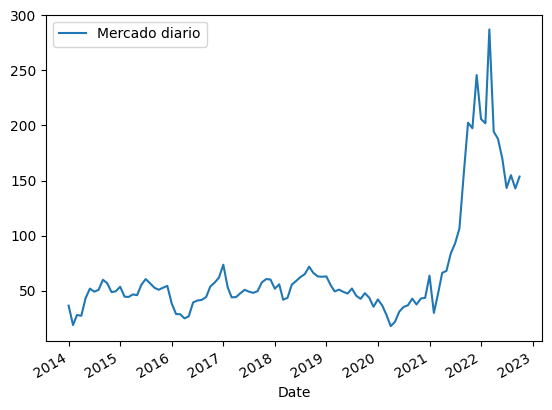

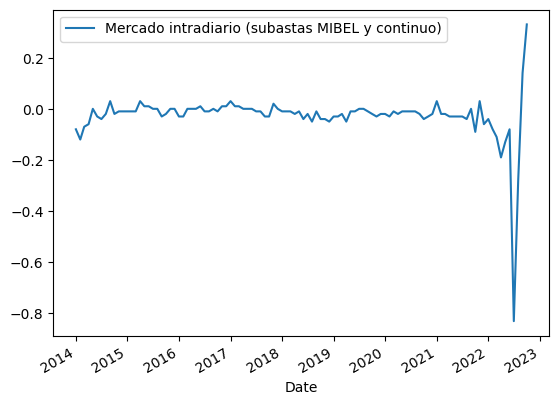

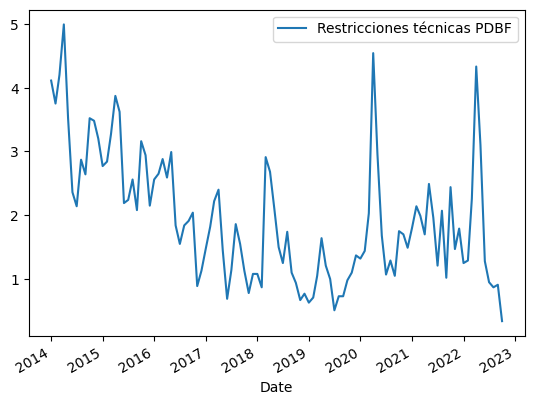

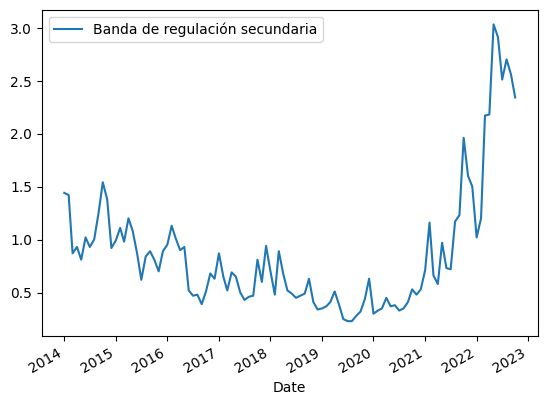

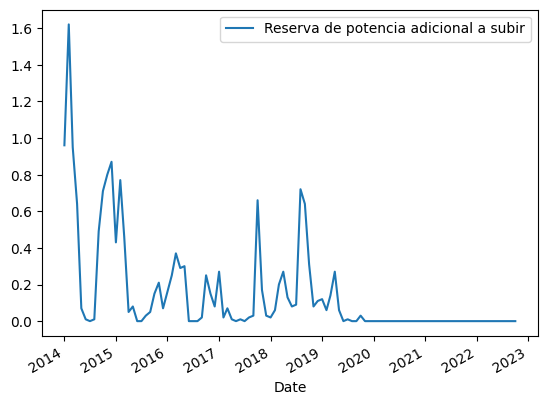

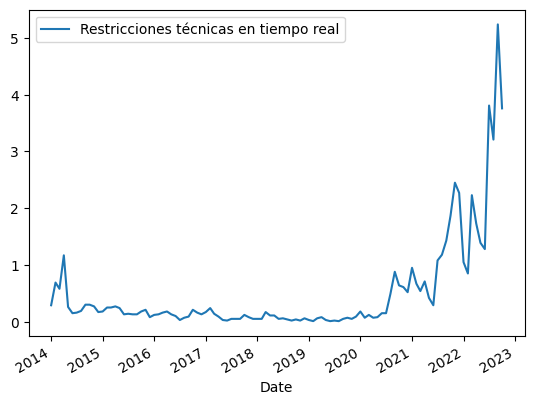

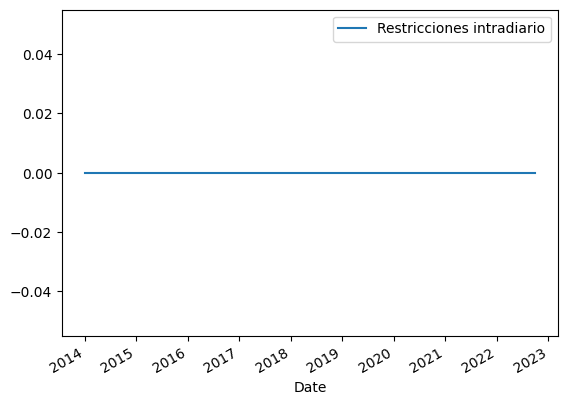

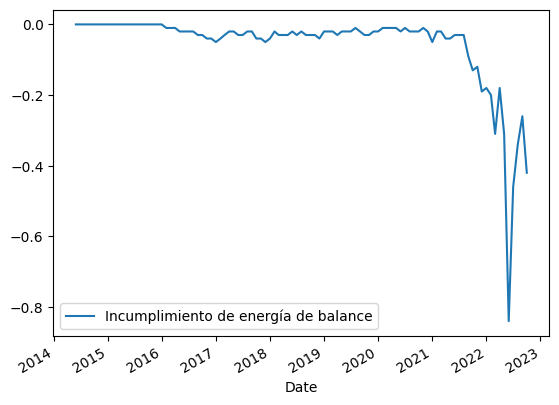

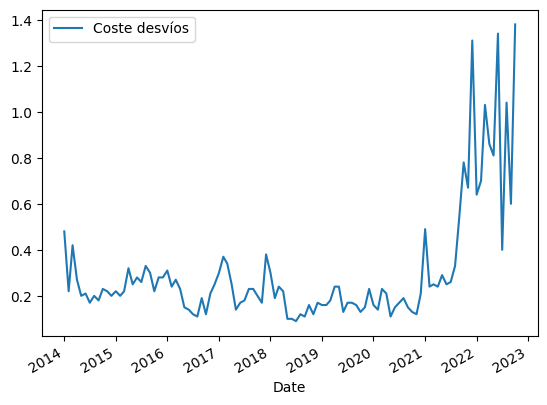

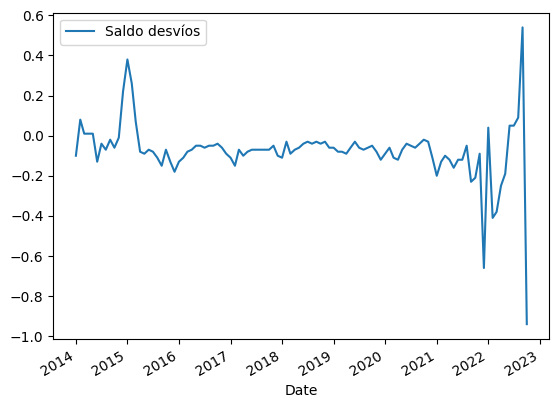

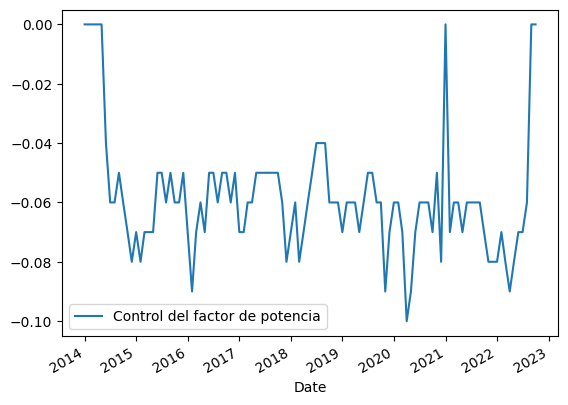

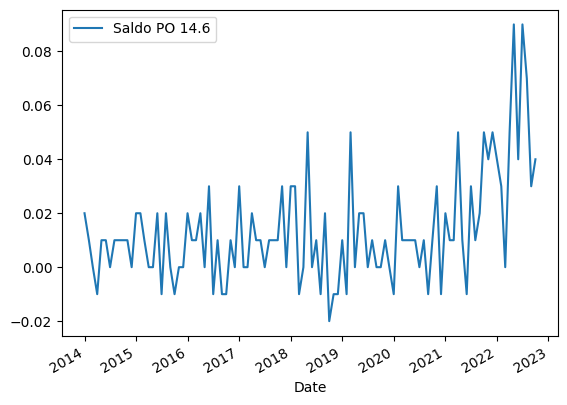

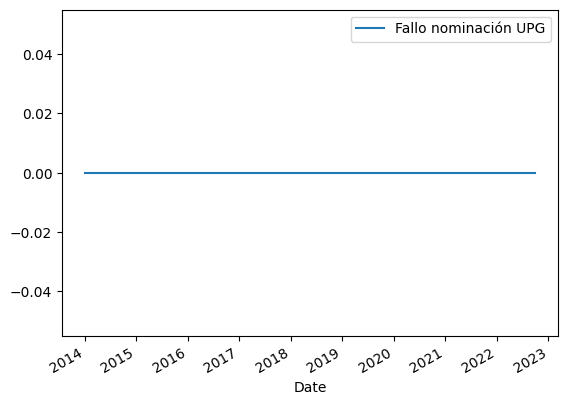

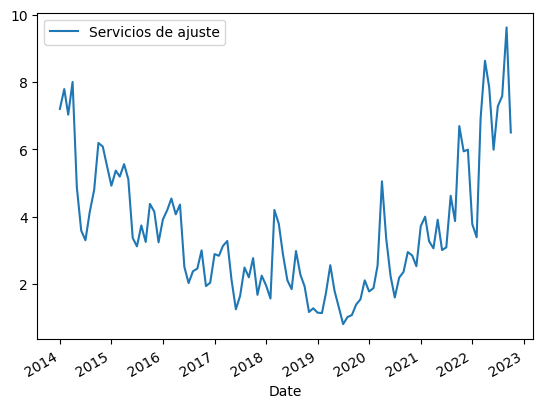

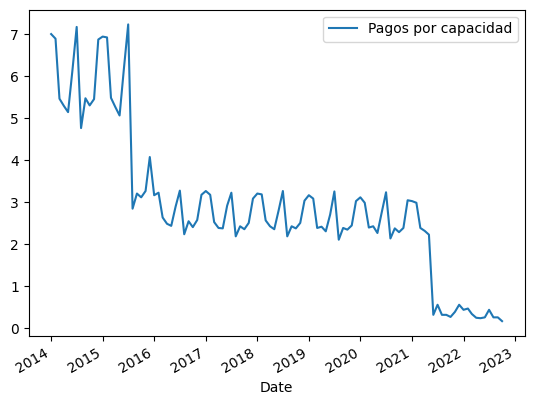

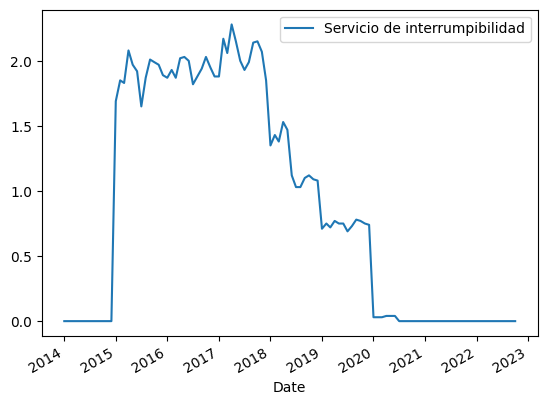

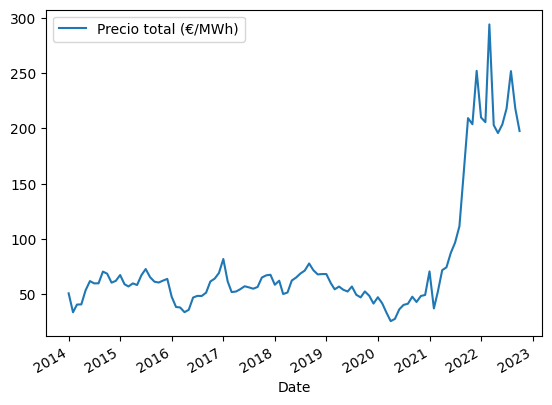

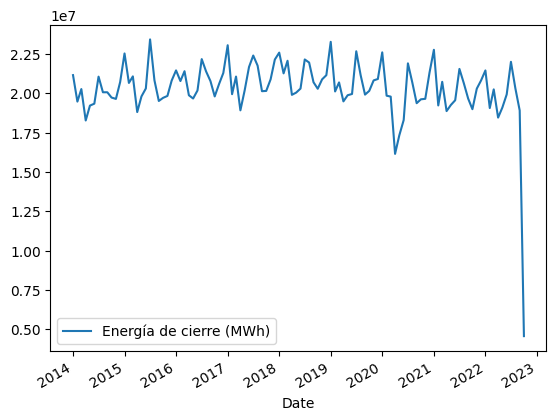

In [29]:
# datos
names = df['Name'].unique()

for name in names:
    dt = df[df['Name'] == name]
    dt.plot('Date','Value',label=name)

In [30]:
df.describe()

,Value
count,1.897000e+03
mean,1.135006e+06
std,4.689863e+06
min,-9.400000e-01
25%,0.000000e+00
50%,1.800000e-01
75%,2.560000e+00
max,2.342458e+07


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Value   1897 non-null   float64
 1   Date    1897 non-null   object 
 2   Name    1897 non-null   object 
 3   Set     1897 non-null   object 
 4   Ud      1897 non-null   object 
dtypes: float64(1), object(4)
memory usage: 74.2+ KB


In [32]:
# Guardamos la serie procesada
dt.to_csv(serhi.OUT_FILE, index=False)
